In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf


In [2]:
# allowing more memory for tensorflow, tensorflow auto use GPU if detected
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'


In [3]:
#dirs
dataset_dir_name = ['blender_parking_dataset']
dataset_dir = 'dataset_big'


In [31]:
import os

for dirpath, dirnames, filenames in os.walk("dataset_big"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

There are 2 directories and 0 images in 'dataset_big'
There are 3 directories and 0 images in 'dataset_big\test'
There are 0 directories and 1000 images in 'dataset_big\test\correct'
There are 0 directories and 1000 images in 'dataset_big\test\empty'
There are 0 directories and 1000 images in 'dataset_big\test\wrong'
There are 3 directories and 0 images in 'dataset_big\train'
There are 0 directories and 5440 images in 'dataset_big\train\correct'
There are 0 directories and 5440 images in 'dataset_big\train\empty'
There are 0 directories and 5440 images in 'dataset_big\train\wrong'


In [32]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#Hyper parameters
IMAGE_SIZE = (140,140)
BATCH_SIZE = 32
EPOCHS = 5

train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("TRAIN DATA GENERATION: ")
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size = IMAGE_SIZE,
                                               batch_size = BATCH_SIZE,
                                               class_mode = "categorical")

print("TEST DATA GENERATION: ")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size = IMAGE_SIZE,
                                             batch_size = BATCH_SIZE,
                                             class_mode = "categorical")

TRAIN DATA GENERATION: 
Found 16320 images belonging to 3 classes.
TEST DATA GENERATION: 
Found 3000 images belonging to 3 classes.


In [37]:
#we will be comparing two Tensorflow Hub models

resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
effficient_net_url = "https://tfhub.dev/google/efficientnet/b0/feature-vector/1"

In [33]:
#Creating a Tensorboard Callback
import datetime
import tensorflow as tf
def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f"Saving the log files to {log_dir}")
    return tensorboard_callback

In [35]:
#import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [36]:
#lets create a function to make a model out of our url models

def create_model(model_url, num_classes = 3):
    """
        This function returns a model using features mentioned in the model_url model from TFHub and also takes number of classes required.
        model_url : The feature extractor model URL from TFHub
        num_classes: Number of output neurons we require in the output layer (default = 10)
    """
    #Download the model and save it as a Keras layer
    feature_extractor_layer = hub.KerasLayer(model_url,
                                             trainable=False, #we want to maintain the model's training data and not make our own custom data
                                             name = "feature_extractor_layer",
                                             input_shape = IMAGE_SIZE + (3,) #equivalent to (140,140,3)
                                             ) 
    
    #Create our own model
    model = tf.keras.Sequential([
        feature_extractor_layer,
        layers.Dense(3, activation="softmax", name="ouput_layer")
    ])

    return model    

In [38]:
resnet_model = create_model(model_url=resnet_url,
                            num_classes=train_data.num_classes)

In [39]:
resnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_layer (Ke  (None, 2048)             23564800  
 rasLayer)                                                       
                                                                 
 ouput_layer (Dense)         (None, 3)                 6147      
                                                                 
Total params: 23,570,947
Trainable params: 6,147
Non-trainable params: 23,564,800
_________________________________________________________________


In [40]:
#Compile our model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [41]:
#Fit the model
history_resnet = resnet_model.fit(train_data,
                                  epochs=5,
                                  steps_per_epoch=len(train_data),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  #Adding Tensorboard callback to model
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", #save log files 
                                                                        experiment_name="resnet50V2")] #name of the log file
                                  )

Saving the log files to tensorflow_hub/resnet50V2/20231103-002015
Epoch 1/5
510/510 [==============================] - 47s 83ms/step - loss: 0.0320 - accuracy: 0.9930 - val_loss: 0.0036 - val_accuracy: 1.0000
Epoch 2/5
510/510 [==============================] - 41s 81ms/step - loss: 0.0022 - accuracy: 0.9999 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 3/5
510/510 [==============================] - 41s 81ms/step - loss: 9.0043e-04 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 4/5
510/510 [==============================] - 42s 82ms/step - loss: 4.9307e-04 - accuracy: 1.0000 - val_loss: 7.9240e-04 - val_accuracy: 1.0000
Epoch 5/5
510/510 [==============================] - 42s 82ms/step - loss: 3.0532e-04 - accuracy: 1.0000 - val_loss: 6.7560e-04 - val_accuracy: 1.0000


In [42]:
resnet_model.evaluate(test_data)

94/94 [==============================] - 7s 67ms/step - loss: 6.7560e-04 - accuracy: 1.0000


[0.0006756008369848132, 1.0]

In [20]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()
  plt.show()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();
  plt.show()

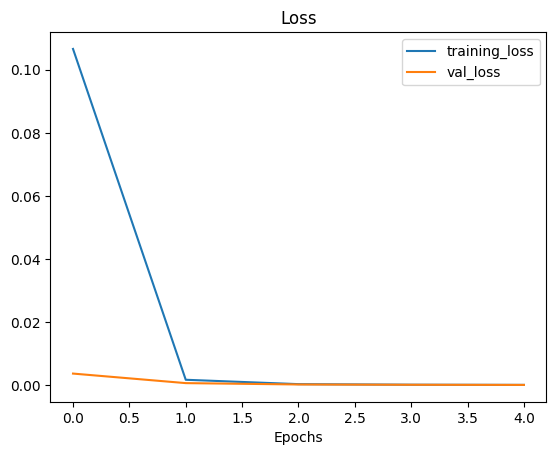

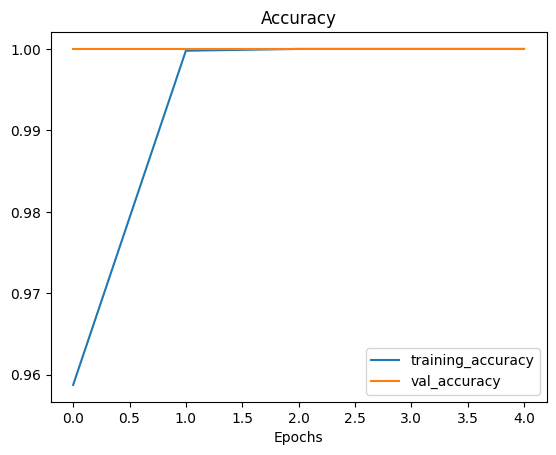

In [43]:
plot_loss_curves(history=history_model)

In [44]:
#Now lets create the efficient net model

efficient_net_model = create_model(model_url=effficient_net_url,
                                   num_classes=train_data.num_classes)

In [45]:
efficient_net_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_layer (Ke  (None, 1280)             4049564   
 rasLayer)                                                       
                                                                 
 ouput_layer (Dense)         (None, 3)                 3843      
                                                                 
Total params: 4,053,407
Trainable params: 3,843
Non-trainable params: 4,049,564
_________________________________________________________________


In [46]:
#Compile the model
efficient_net_model.compile(loss="categorical_crossentropy",
                            metrics=["accuracy"],
                            optimizer=tf.keras.optimizers.Adam())

In [47]:
#Fit the model
effficient_net_history = efficient_net_model.fit(train_data,
                                                epochs=5,
                                                steps_per_epoch=len(train_data),
                                                validation_data=test_data,
                                                validation_steps=len(test_data),
                                                callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                    experiment_name="efficientNetB0")]
                                                                                    )

Saving the log files to tensorflow_hub/efficientNetB0/20231103-002809
Epoch 1/5
510/510 [==============================] - 29s 49ms/step - loss: 0.0408 - accuracy: 0.9914 - val_loss: 0.0042 - val_accuracy: 1.0000
Epoch 2/5
510/510 [==============================] - 24s 46ms/step - loss: 0.0041 - accuracy: 0.9998 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 3/5
510/510 [==============================] - 24s 47ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 8.1122e-04 - val_accuracy: 1.0000
Epoch 4/5
510/510 [==============================] - 24s 47ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 5.1441e-04 - val_accuracy: 1.0000
Epoch 5/5
510/510 [==============================] - 24s 47ms/step - loss: 6.4012e-04 - accuracy: 1.0000 - val_loss: 3.4009e-04 - val_accuracy: 1.0000


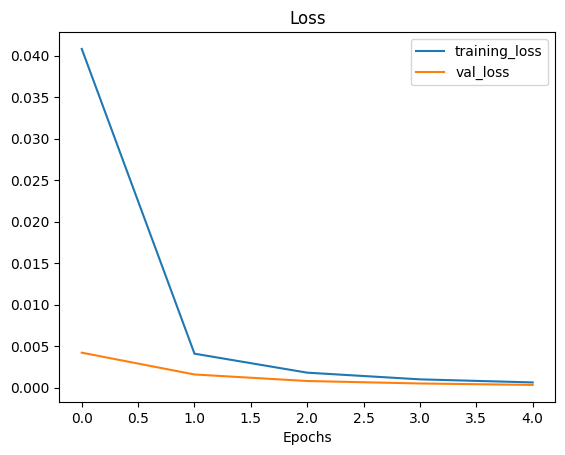

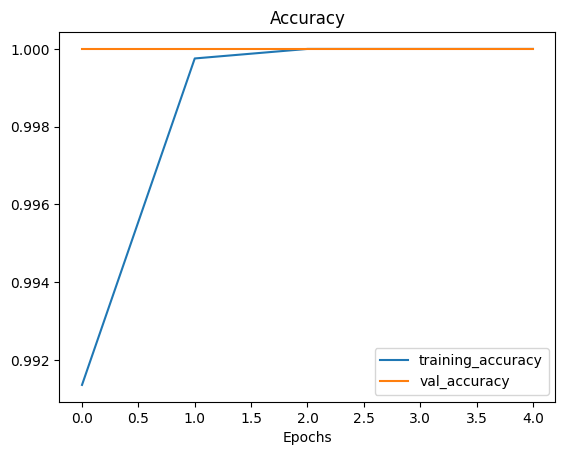

In [48]:
plot_loss_curves(history=effficient_net_history)

In [49]:
efficient_net_model.save_weights('my_checkpoint')
efficient_net_model.save("my_model")

INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets
